In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Parameters
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).float() // (256 // PIXEL_LEVELS))
])
path = "./data"
dataset = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 26.4M/26.4M [00:07<00:00, 3.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.11MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [11]:
# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, h, w = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [13]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(filters, filters // 2, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', filters // 2, filters // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(filters // 2, filters, kernel_size=1)
        )

    def forward(self, x):
        return x + self.block(x)

In [16]:
# PixelCNN Model
class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            MaskedConv2d('A', 1, N_FILTERS, kernel_size=7, padding=3),
            *[ResidualBlock(N_FILTERS) for _ in range(RESIDUAL_BLOCKS)],
            nn.ReLU(),
            MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(N_FILTERS, PIXEL_LEVELS, kernel_size=1)
        )

    def forward(self, x):
        return self.model(x)

model = PixelCNN().to(DEVICE)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        
        images = images.to(DEVICE).squeeze(1)
        optimizer.zero_grad()
        inputs = images.float().unsqueeze(1)     # [batch, 1, H, W]
        targets = images.long()                  # [batch, H, W]
        outputs = model(inputs)                  # [batch, PIXEL_LEVELS, H, W]       
        loss = criterion(outputs, targets)       # CrossEntropy expects float inputs and long targets 
        loss.backward()
        optimizer.step() 
        total_loss += loss.item()   
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1/2: 100%|██████████| 469/469 [05:06<00:00,  1.53it/s]


Epoch 1, Loss: 0.4269


Epoch 2/2: 100%|██████████| 469/469 [09:12<00:00,  1.18s/it]  

Epoch 2, Loss: 0.3350


In [19]:
def generate_images(model, num_images, temperature=1.0):
    model.eval()
    generated = torch.zeros(num_images, 1, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
    with torch.no_grad():
        for row in range(IMAGE_SIZE):
            for col in range(IMAGE_SIZE):
                logits = model(generated.float())[:, :, row, col] / temperature
                probs = torch.softmax(logits, dim=-1)
                generated[:, 0, row, col] = torch.multinomial(probs, 1).squeeze(-1)
    return generated.cpu().numpy() / PIXEL_LEVELS

# Generate sample images
sample_images = generate_images(model, num_images=10)
print("Generated images shape:", sample_images.shape)


Generated images shape: (10, 1, 16, 16)


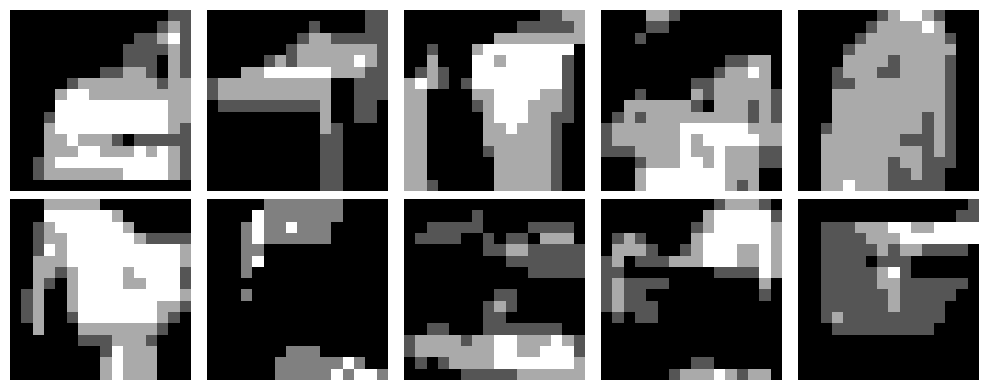

In [20]:
def plot_generated_images(images, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))

    for idx, img in enumerate(images):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate sample images (assuming you've done this step already)
sample_images = generate_images(model, num_images=10, temperature=1.0)
# Plot generated images
plot_generated_images(sample_images)
